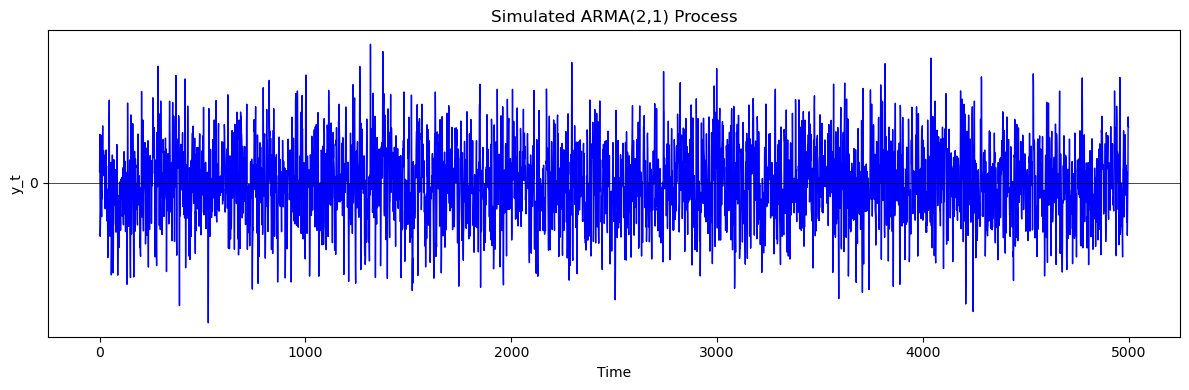

ADF Test: Stationary (p-value = 0.000)


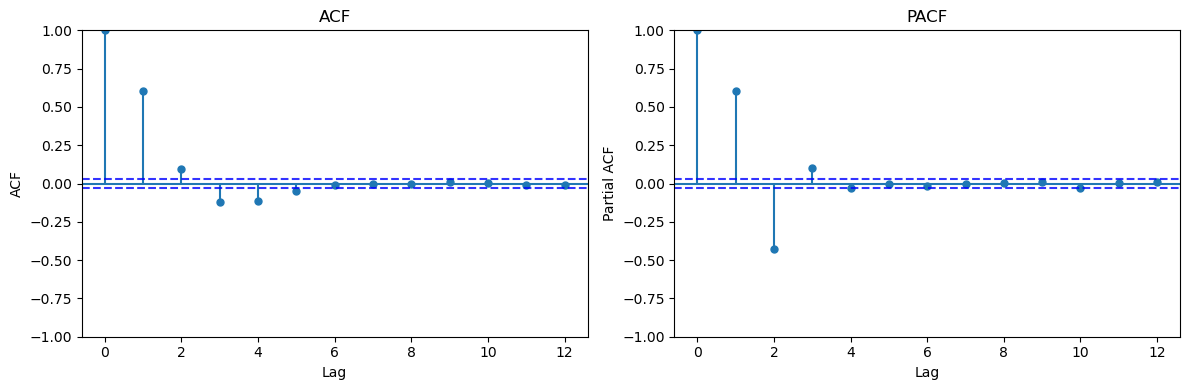

Best model: ARMA(2, 1) with AIC = 14206.77

Residuals Analysis:


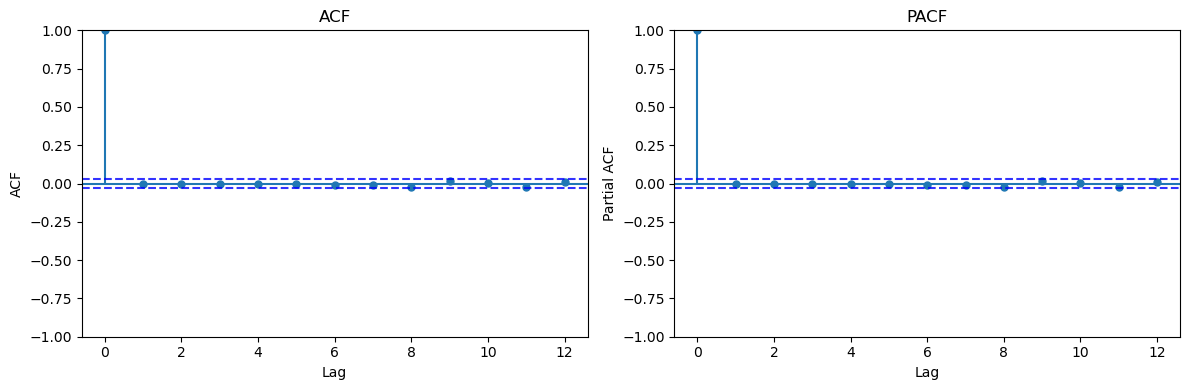

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5000
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -7098.387
Date:                Mon, 07 Jul 2025   AIC                          14206.773
Time:                        11:11:20   BIC                          14239.359
Sample:                             0   HQIC                         14218.194
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0265      0.028     -0.964      0.335      -0.080       0.027
ar.L1          0.6671      0.029     22.860      0.000       0.610       0.724
ar.L2         -0.3079      0.022    -14.235      0.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Simulate ARMA(2,1) process
# -------------------------------
np.random.seed(231)
n = 5000
arparams = np.array([0.68, -0.32])
maparams = np.array([0.24])
ar = np.r_[1, -arparams]  # add zero-lag and invert signs
ma = np.r_[1, maparams]   # add zero-lag
ts = sm.tsa.ArmaProcess(ar, ma).generate_sample(nsample=n)

# -------------------------------
# Plot simulated ARMA(2,1)
# -------------------------------
plt.figure(figsize=(12, 4))
plt.plot(ts, color='blue', linewidth=1)
plt.title("Simulated ARMA(2,1) Process")
plt.xlabel("Time")
plt.ylabel("y_t")
plt.axhline(y=0, color='black', linewidth=0.5)
plt.yticks([0])
plt.tight_layout()
plt.show()

# -------------------------------
# Check stationarity (ADF Test)
# -------------------------------
adf_result = adfuller(ts)
stationary_check = "Stationary" if adf_result[1] < 0.05 else "Not stationary"
print(f"ADF Test: {stationary_check} (p-value = {adf_result[1]:.3f})")

# -------------------------------
# Custom ACF and PACF plots with desired styling
# -------------------------------
def plot_custom_acf_pacf(data, lags=12, figsize=(12, 4)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # ACF plot
    plot_acf(data, lags=lags, ax=axes[0], alpha=None)
    axes[0].set_title("ACF")
    axes[0].set_xlabel("Lag")
    axes[0].set_ylabel("ACF")
    
    # Add dashed horizontal lines at confidence intervals
    n = len(data)
    ci = 1.96 / np.sqrt(n)
    axes[0].axhline(y=ci, color='blue', linestyle='--', alpha=0.8)
    axes[0].axhline(y=-ci, color='blue', linestyle='--', alpha=0.8)
    
    # PACF plot
    plot_pacf(data, lags=lags, ax=axes[1], alpha=None)
    axes[1].set_title("PACF")
    axes[1].set_xlabel("Lag")
    axes[1].set_ylabel("Partial ACF")
    
    # Add dashed horizontal lines at confidence intervals
    axes[1].axhline(y=ci, color='blue', linestyle='--', alpha=0.8)
    axes[1].axhline(y=-ci, color='blue', linestyle='--', alpha=0.8)
    
    plt.tight_layout()
    plt.show()

# Plot ACF and PACF with custom styling
plot_custom_acf_pacf(ts, lags=12)

# -------------------------------
# Find best ARMA(p, q) using AIC
# -------------------------------
def best_arma_model(data, max_p=3, max_q=3, alpha=0.05):
    best_aic = np.inf
    best_order = None
    best_model = None
    results = []
    
    for p in range(1, max_p+1):
        for q in range(0, max_q+1):
            try:
                model = ARIMA(data, order=(p, 0, q)).fit()
                pval = sm.stats.acorr_ljungbox(model.resid, lags=[p+q+1], return_df=True)['lb_pvalue'].iloc[0]
                if pval >= alpha:
                    results.append(((p, q), model.aic))
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, q)
                        best_model = model
                else:
                    print(f"WARNING: Correlated residuals in ARMA({p},{q})")
            except Exception as e:
                print(f"Skipping ARMA({p},{q}): {e}")
    
    results_df = pd.DataFrame(results, columns=["Order", "AIC"]).sort_values(by="AIC")
    return best_order, best_model, results_df

best_order, best_model, aic_table = best_arma_model(ts, max_p=3, max_q=3)
print(f"Best model: ARMA{best_order} with AIC = {best_model.aic:.2f}")

# -------------------------------
# Plot residual ACF and PACF with custom styling
# -------------------------------
residuals = best_model.resid
print("\nResiduals Analysis:")
plot_custom_acf_pacf(residuals, lags=12)

# Print model summary
print(best_model.summary())